# (21) Simulation -- explore

**Motivation**: Figure out what went wrong previously. <br>

In [1]:
# HIDE CODE


import os
import sys
from copy import deepcopy as dc
from os.path import join as pjoin
from IPython.display import display, IFrame, HTML

# tmp & extras dir
git_dir = pjoin(os.environ['HOME'], 'Dropbox/git')
extras_dir = pjoin(git_dir, 'jb-MTMST/_extras')
fig_base_dir = pjoin(git_dir, 'jb-MTMST/figs')
tmp_dir = pjoin(git_dir, 'jb-MTMST/tmp')

# GitHub
sys.path.insert(0, pjoin(git_dir, '_MTMST'))
from analysis.opticflow import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
from rich.jupyter import print
%matplotlib inline
set_style()

In [2]:
def do(x, y, z=10):
    alpha_x = np.arctan(x/z)
    alpha_y = np.arctan(y/z)
    rho = np.sqrt(alpha_x ** 2 + alpha_y ** 2)
    return rho

In [3]:
num = 500
rho = np_nans((num, num))
for i, x in enumerate(np.linspace(-100, 100, num)):
    for j, y in enumerate(np.linspace(-100, 100, num)):
        rho[j, i] = do(x, y, z=10)

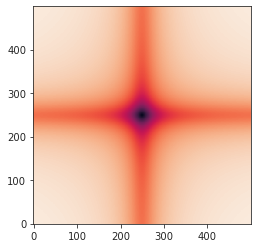

In [4]:
fig, ax = create_figure()
ax.imshow(rho)
ax.invert_yaxis()

In [5]:
do(1,1)

0.14095276009645233

In [6]:
from scipy.spatial.transform import Rotation as rot

def cart2polar(e):
    r = sp_lin.norm(e, ord=2)
    theta = np.arccos(e[2] / r)
    phi = np.arctan2(e[1], e[0])
    return (r, theta, phi)


def polar2cart(e):
    r, theta, phi = e
    return (
        r * np.sin(theta) * np.cos(phi),
        r * np.sin(theta) * np.sin(phi),
        r * np.cos(theta),
    )

In [64]:
def test_rot(theta, phi):
    theta = np.deg2rad(theta)
    phi = np.deg2rad(phi)
    f_hat = polar2cart((1, theta, phi))
    f_hat = np.array(f_hat)

    u = np.array((-np.sin(phi), np.cos(phi), 0))
    r = rot.from_rotvec(theta * u)

    dot = np.dot(f_hat, r.apply((0, 0, 1)))
    delta = np.array(r.apply((0, 0, 1))) - f_hat
    return dot, delta.sum()

In [86]:
dot = np_nans((90, 360))
delta = np_nans((90, 360))
for i, theta in enumerate(np.linspace(0, 90, 90)):
    for j, phi in enumerate(np.linspace(0, 360, 360)):
        dot[i, j], delta[i, j] = test_rot(theta, phi)

collections.Counter(np.round(dot.ravel(), 15)), collections.Counter(np.round(delta.ravel(), 14))

(Counter({1.0: 32400}), Counter({0.0: 32400}))

In [122]:
theta = 30
phi = 0

theta = np.deg2rad(theta)
phi = np.deg2rad(phi)
u = np.array((-np.sin(phi), np.cos(phi), 0))
r = rot.from_rotvec(theta * u)
m = r.as_matrix()

In [123]:
f_hat = polar2cart((1, theta, phi))
f_hat = np.array(f_hat)

In [124]:
applied = m.T @ f_hat.reshape(-1, 1)
np.round(applied, 15)

array([[-0.],
       [ 0.],
       [ 1.]])

In [125]:
x_prime = m.T @ np.array([1, 0, 0]).reshape(-1, 1)
y_prime = m.T @ np.array([0, 1, 0]).reshape(-1, 1)
z_prime = m.T @ np.array([0, 0, 1]).reshape(-1, 1)
x_prime, y_prime, z_prime

(array([[0.8660254],
        [0.       ],
        [0.5      ]]),
 array([[0.],
        [1.],
        [0.]]),
 array([[-0.5      ],
        [ 0.       ],
        [ 0.8660254]]))

$\Theta - \theta, \Phi - \phi$

In [140]:
def test_mat(theta, phi):
    theta = np.deg2rad(theta)
    phi = np.deg2rad(phi)
    c = np.cos(phi)
    s = np.sin(phi)

    u = np.array((-s, c, 0))
    r = rot.from_rotvec(theta * u)
    m = r.as_matrix()

    m2 = np.array([
        [s**2 + np.cos(theta) * c**2, -c*s*(1-np.cos(theta)), c * np.sin(theta)],
        [-c*s*(1-np.cos(theta)), c**2 + s**2 * np.cos(theta), s * np.sin(theta)],
        [-c * np.sin(theta), -s * np.sin(theta), np.cos(theta)],
    ])
    delta = (m - m2).sum()
    dot = np.dot(m.ravel(), m2.ravel())
    return dot, delta

In [146]:
dot = np_nans((90, 360))
delta = np_nans((90, 360))
for i, theta in enumerate(np.linspace(0, 90, 90)):
    for j, phi in enumerate(np.linspace(0, 360, 360)):
        dot[i, j], delta[i, j] = test_mat(theta, phi)

collections.Counter(np.round(dot.ravel(), 14)), collections.Counter(np.round(delta.ravel(), 14))

(Counter({3.0: 32400}), Counter({0.0: 32400}))

In [149]:
sp_lin.det(m), sp_lin.det(m2)

(1.0, 1.0)

In [50]:
theta = np.deg2rad(30)
phi = np.deg2rad(0)

e = polar2cart((1, theta, phi))
np.round(e, 13)

array([0.5      , 0.       , 0.8660254])

In [51]:
r = rot.from_rotvec((np.pi/2 - theta) * np.array([0, 1, 0]))
np.round(r.apply(e), 13)

array([1., 0., 0.])

In [53]:
np.round(cart2polar(e), 13)

array([1.        , 0.52359878, 0.        ])

In [54]:
alpha_y = np.arctan(np.tan(theta) * np.sin(phi))
alpha_x = np.arctan(np.tan(theta) * np.cos(phi) * -1)
alpha_x, alpha_y

(-0.5235987755982988, 0.0)

In [58]:
r = rot.from_rotvec(alpha_x * np.array([0, 1, 0]))
r.apply(e)

array([0., 0., 1.])

In [60]:
cart2polar(r.apply(e))

(1.0, 0.0, 0.0)

In [64]:
theta = np.deg2rad(30)
phi = np.deg2rad(0)

e = polar2cart((1, theta, phi))

alpha_y = np.arctan(np.tan(theta) * np.sin(phi))
alpha_x = np.arctan(np.tan(theta) * np.cos(phi) * -1)

In [65]:
r = rot.from_rotvec(alpha_x * np.array([0, 1, 0]))
e = r.apply(e)
e

array([0., 0., 1.])

In [66]:
r = rot.from_rotvec(alpha_y * np.array([1, 0, 0]))
e = r.apply(e)
e

array([0., 0., 1.])

In [182]:
def do_it(theta, phi):
    theta = np.deg2rad(theta)
    phi = np.deg2rad(phi)
    
    e = polar2cart((1, theta, phi))
    alpha_y = np.arctan(np.tan(theta) * np.sin(phi))
    alpha_x = np.arctan(np.tan(theta) * np.cos(phi))
    r = (
        alpha_y * np.array([1, 0, 0]) -
        alpha_x * np.array([0, 1, 0])
    )
    r = rot.from_rotvec(r)
    e = r.apply(e)
    return e, alpha_y, alpha_x

In [183]:
do_it(60, 20)

(array([-0.04136749, -0.15224934,  0.98747601]),
 0.5348097592591339,
 1.019853408583384)

In [184]:
do_it(85, 20)

(array([-0.08902377, -0.57511191,  0.81321649]),
 1.320366578286758,
 1.477960460286924)

In [185]:
do_it(90, 1)

(array([ 0.18310838, -0.79928691,  0.57237379]),
 1.570796326794893,
 1.5707963267948966)

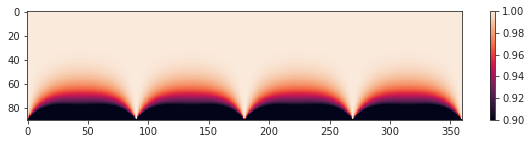

In [186]:
results = np_nans((90, 360))
for i, theta in enumerate(np.linspace(0, 90, 90)):
    for j, phi in enumerate(np.linspace(0, 360, 360)):
        results[i, j] = do_it(theta, phi)[0][-1]
        
fig, ax = create_figure(figsize=(10, 2))
im = ax.imshow(results, vmin=0.9, vmax=1)
plt.colorbar(im, ax=ax);

In [276]:
def do_it(theta, phi, dtype='float128'):
    theta = np.deg2rad(theta)
    phi = np.deg2rad(phi)
    
    s = np.sin(theta, dtype=dtype)
    ss = s * np.sin(phi, dtype=dtype)
    sc = s * np.cos(phi, dtype=dtype)
    
    alpha_x = np.arcsin(sc,dtype=dtype)
    alpha_y = np.arcsin(ss, dtype=dtype)

    r = (
        alpha_y * np.array([1, 0, 0]) -
        alpha_x * np.array([0, 1, 0])
    )
    r = rot.from_rotvec(r)
    
    e = polar2cart((1, theta, phi))
    e = r.apply(e)
    return e, alpha_y, alpha_x

In [277]:
do_it(60, 20)

(array([0.03620101, 0.05023057, 0.99808135]),
 0.3007096981554272101,
 0.95065732066284231155)

In [278]:
do_it(85, 20)

(array([0.19295212, 0.12742838, 0.9728985 ]),
 0.34768118225047248647,
 1.2114213108598165137)

In [279]:
do_it(90, 1)

(array([0.01728308, 0.00641235, 0.99983007]),
 0.017453292519943295474,
 1.553343034274953324)

In [280]:
do_it(90, 45)

(array([0.31396661, 0.31396661, 0.89601894]),
 0.785398163397448279,
 0.78539816339744834026)

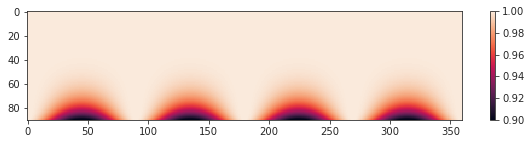

In [281]:
results = np_nans((90, 360))
for i, theta in enumerate(np.linspace(0, 90, 90)):
    for j, phi in enumerate(np.linspace(0, 360, 360)):
        results[i, j] = do_it(theta, phi)[0][-1]

fig, ax = create_figure(figsize=(10, 2))
im = ax.imshow(results, vmin=0.9, vmax=1)
plt.colorbar(im, ax=ax);

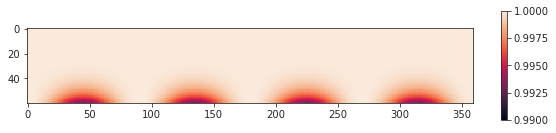

In [285]:
results = np_nans((60, 360))
for i, theta in enumerate(np.linspace(0, 60, 60)):
    for j, phi in enumerate(np.linspace(0, 360, 360)):
        results[i, j] = do_it(theta, phi)[0][-1]

fig, ax = create_figure(figsize=(10, 2))
im = ax.imshow(results, vmin=0.99, vmax=1)
plt.colorbar(im, ax=ax);

In [230]:
def do_it_jan21(theta, phi, dtype='float128'):
    theta = np.deg2rad(theta)
    phi = np.deg2rad(phi)

    t = np.tan(theta, dtype=dtype)
    ts = t * np.sin(phi, dtype=dtype)
    tc = t * np.cos(phi, dtype=dtype)

    alpha_x = np.arctan2(tc, np.sqrt(1 + ts**2), dtype=dtype)
    alpha_y = np.arctan2(ts, np.sqrt(1 + tc**2), dtype=dtype)

    r = (
        alpha_y * np.array([1, 0, 0], dtype=dtype) -
        alpha_x * np.array([0, 1, 0], dtype=dtype)
    )
    r = rot.from_rotvec(r)

    e = polar2cart((1, theta, phi))
    e = r.apply(e)
    return e, alpha_y, alpha_x

In [225]:
do_it_jan21(60, 20)

(array([0.03620101, 0.05023057, 0.99808135]),
 0.3007096981554272101,
 0.95065732066284231155)

In [228]:
do_it_jan21(90, 1)

(array([0.01728308, 0.00641235, 0.99983007]),
 0.017453292519943295474,
 1.5533430342749533238)

In [237]:
e, alpha_y, alpha_x =  do_it_jan21(90, 45)
np.rad2deg(alpha_x), np.rad2deg(alpha_y)

(45.000000000000001756, 44.999999999999998244)

In [241]:
e, alpha_y, alpha_x =  do_it_jan21(90, 0)
np.rad2deg(alpha_x), np.rad2deg(alpha_y)

(89.99999999999999649, 0.0)

In [245]:
np.rad2deg(np.arcsin(0.5))

30.000000000000004

In [254]:
theta = np.arctan(np.sqrt(2))
np.rad2deg(theta)

54.735610317245346

In [257]:
1 / (np.cos(theta) ** 2)

3.0

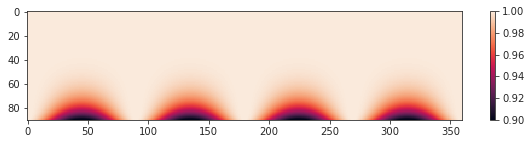

In [231]:
results = np_nans((90, 360))
for i, theta in enumerate(np.linspace(0, 90, 90)):
    for j, phi in enumerate(np.linspace(0, 360, 360)):
        results[i, j] = do_it_jan21(theta, phi)[0][-1]

fig, ax = create_figure(figsize=(10, 2))
im = ax.imshow(results, vmin=0.9, vmax=1)
plt.colorbar(im, ax=ax);

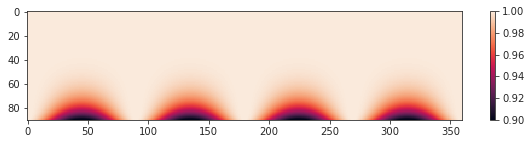

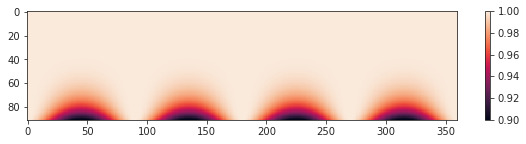

In [243]:
results = np_nans((91, 360))
for i, theta in enumerate(np.linspace(0, 90, 91)):
    for j, phi in enumerate(np.linspace(0, 360, 360)):
        results[i, j] = do_it_jan21(theta, phi)[0][-1]

fig, ax = create_figure(figsize=(10, 2))
im = ax.imshow(results, vmin=0.9, vmax=1)
plt.colorbar(im, ax=ax);

In [270]:
def do_it_cos(theta, phi, dtype='float128'):
    theta = np.deg2rad(theta)
    phi = np.deg2rad(phi)

    c = np.cos(theta, dtype=dtype)
    s = np.sin(theta, dtype=dtype)
    sc = s * np.cos(phi, dtype=dtype)
    ss = s * np.cos(np.pi / 2 - phi, dtype=dtype)

    alpha_x = np.arccos(np.sqrt(c**2 + ss**2), dtype=dtype)
    alpha_y = np.arccos(np.sqrt(c**2 + sc**2), dtype=dtype)

    if alpha_x < 0:
        alpha_x += 2 * np.pi
    if alpha_y < 0:
        alpha_y += 2 * np.pi

    r = (
        alpha_y * np.array([1, 0, 0], dtype=dtype) -
        alpha_x * np.array([0, 1, 0], dtype=dtype)
    )
    r = rot.from_rotvec(r)

    e = polar2cart((1, theta, phi))
    e = r.apply(e)
    return e, alpha_y, alpha_x

In [271]:
do_it_cos(60, 20)

(array([0.03620101, 0.05023057, 0.99808135]),
 0.30070969815542721016,
 0.950657320662842252)

In [272]:
do_it_cos(85, 20)

(array([0.19295212, 0.12742838, 0.9728985 ]),
 0.3476811822504724864,
 1.2114213108598164004)

In [273]:
do_it_cos(90, 1)

(array([0.01728308, 0.00641235, 0.99983007]),
 0.017453292519943295276,
 1.5533430342749532382)

In [274]:
do_it_cos(90, 45)

(array([0.31396661, 0.31396661, 0.89601894]),
 0.785398163397448279,
 0.785398163397448279)

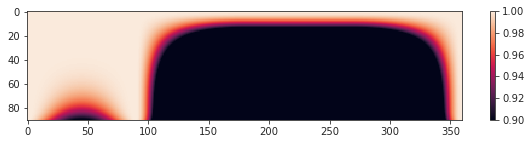

In [275]:
results = np_nans((90, 360))
for i, theta in enumerate(np.linspace(0, 90, 90)):
    for j, phi in enumerate(np.linspace(0, 360, 360)):
        results[i, j] = do_it_cos(theta, phi)[0][-1]

fig, ax = create_figure(figsize=(10, 2))
im = ax.imshow(results, vmin=0.9, vmax=1)
plt.colorbar(im, ax=ax);

In [293]:
def do_it_best(theta, phi, dtype='float128'):
    theta = np.deg2rad(theta)
    phi = np.deg2rad(phi)
    
    s = np.sin(theta, dtype=dtype)
    ss = s * np.sin(phi, dtype=dtype)
    sc = s * np.cos(phi, dtype=dtype)
    
    alpha_x = np.arcsin(sc,dtype=dtype)
    alpha_y = np.arcsin(ss, dtype=dtype)
    
    rx = np.array([1, 0, 0], dtype=dtype)
    rx = rot.from_rotvec(rx * alpha_y)
    y_new = rx.apply([0, 1, 0])
    ry = rot.from_rotvec(y_new * alpha_x * -1)

    e = polar2cart((1, theta, phi))
    ex = rx.apply(e)
    ey = ry.apply(ex)
    return ey, alpha_y, alpha_x

In [294]:
do_it_best(60, 20)

(array([6.60382894e-02, 6.77022362e-04, 9.97816860e-01]),
 0.3007096981554272101,
 0.95065732066284231155)

In [295]:
do_it_best(85, 20)

(array([0.24763426, 0.01131148, 0.96878755]),
 0.34768118225047248647,
 1.2114213108598165137)

In [296]:
do_it_best(90, 1)

(array([1.74497484e-02, 2.65768119e-06, 9.99847742e-01]),
 0.017453292519943295474,
 1.553343034274953324)

In [297]:
do_it_best(90, 45)

(array([0.5       , 0.14644661, 0.85355339]),
 0.785398163397448279,
 0.78539816339744834026)

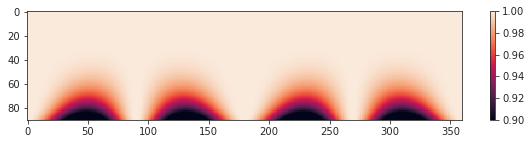

In [298]:
results = np_nans((90, 360))
for i, theta in enumerate(np.linspace(0, 90, 90)):
    for j, phi in enumerate(np.linspace(0, 360, 360)):
        results[i, j] = do_it_best(theta, phi)[0][-1]

fig, ax = create_figure(figsize=(10, 2))
im = ax.imshow(results, vmin=0.9, vmax=1)
plt.colorbar(im, ax=ax);

## Two proposals

### One:
This is obtained by rotating yourself along x or y axis and finding angles such that the cosine ($\Delta \sigma$) becomes smallest at an appropriate angle.  The current weirness occurs when $\theta \to \infty$.  My choice, at the moment:
$$\tan\alpha = \tan\theta \cos\phi$$
$$\tan\beta = \tan\theta \sin\phi$$

Given $(\alpha, \beta)$ you can find $(\theta, \phi)$ like this:
$$\tan\theta = \sqrt{\tan^2\alpha + \tan^2\beta}$$
$$\tan\phi = \frac{\tan\beta}{\tan\alpha}$$

**Edit (5:26 pm):** I am convinced that this is the correct way. Just see this:

$$x = r\sin\theta \cos\phi = z\tan\alpha$$
$$x = r\sin\theta \sin\phi = z\tan\beta$$

For example, if $z$ is fixed, there is a direct way of going from $(\alpha, \beta)$ pairs to $(x, y)$ pairs:

$$z\tan\alpha = x$$
$$z\tan\beta = y$$
$$r = \sqrt{x^2 + y^2 + z^2}$$


### Two:
This happens when you project with straight lines from point to xz and yz planes.  Then find cosine ($\Delta \sigma$) between projected points and the main point.  This behaves better when $\theta \to \infty$, but I think the previous option makes more sense. Here it is:
$$\sin\alpha = \sin\theta \cos\phi$$
$$\sin\beta = \sin\theta \sin\phi$$

Similar to above, given $(\alpha, \beta)$ you can find $(\theta, \phi)$ like this:
$$\sin\theta = \sqrt{\sin^2\alpha + \sin^2\beta}$$
$$\sin\phi = \frac{\sin\beta}{\sin\alpha}$$

In [2]:
def one(a, b, dtype='float128'):
    ta = np.tan(a, dtype=dtype)
    tb = np.tan(b, dtype=dtype)
    theta = np.arctan(
        np.sqrt(ta**2 + tb**2),
        dtype=dtype,
    )
    phi = np.arctan2(tb, ta, dtype=dtype)
    phi[phi < 0] += 2 * np.pi
    return theta, phi


def two(a, b):
    sa = np.sin(a)
    sb = np.sin(b)
    theta = np.arcsin(np.sqrt(sa**2 + sb**2))
    phi = np.arcsin(sb, sa)
    phi[phi < 0] += 2 * np.pi
    return theta, phi

### High res

In [3]:
resolution = 0.01
fov = 60
extent = 90

span = np.linspace(-extent, extent, int(np.round(2 * extent / resolution)) + 1)
span = np.deg2rad(span)

alpha_x, alpha_y = np.meshgrid(span, span)
len(span), alpha_x.shape, alpha_y.shape

(18001, (18001, 18001), (18001, 18001))

In [4]:
ticks, ticklabels = zip(*[
    (i, str(int(np.round(np.rad2deg(x)))))
    for i, x in enumerate(span) if i % 3000 == 0
])
ticklabels

('-90', '-60', '-30', '0', '30', '60', '90')

/tmp/ipykernel_24596/3036145813.py:16: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(np.sqrt(sa**2 + sb**2))


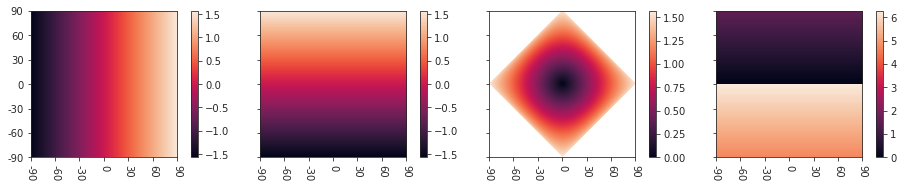

In [5]:
theta, phi = two(alpha_x, alpha_y)

fig, axes = create_figure(1, 4, (12.5, 2.5), 'all', 'all', constrained_layout=True)
for i in range(2):
    im = axes[i].imshow(alpha_x if i == 0 else alpha_y)
    plt.colorbar(im, ax=axes[i])

    im = axes[2 + i].imshow(theta if i == 0 else phi)
    plt.colorbar(im, ax=axes[2 + i])

axes[-1].invert_yaxis()
axes[-1].set(
    xticks=ticks,
    yticks=ticks,
    xticklabels=ticklabels,
    yticklabels=ticklabels,
)
for ax in axes.flat:
    ax.tick_params(axis='x', rotation=-90)

In [6]:
theta, phi = one(alpha_x, alpha_y)

/home/hadi/anaconda3/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Casting input data from 'float128' to 'float64' for imshow
  fig.canvas.print_figure(bytes_io, **kw)


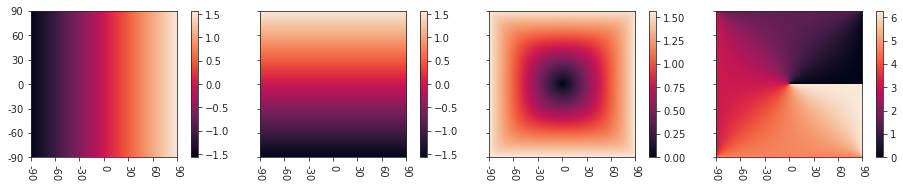

In [7]:
fig, axes = create_figure(1, 4, (12.5, 2.5), 'all', 'all', constrained_layout=True)
for i in range(2):
    im = axes[i].imshow(alpha_x if i == 0 else alpha_y)
    plt.colorbar(im, ax=axes[i])

    im = axes[2 + i].imshow(theta if i == 0 else phi)
    plt.colorbar(im, ax=axes[2 + i])

axes[-1].invert_yaxis()
axes[-1].set(
    xticks=ticks,
    yticks=ticks,
    xticklabels=ticklabels,
    yticklabels=ticklabels,
)
for ax in axes.flat:
    ax.tick_params(axis='x', rotation=-90)

In [8]:
ticks, ticklabels = zip(*[
    (i, str(int(np.round(np.rad2deg(x)))))
    for i, x in enumerate(span) if i % 1500 == 0
])
ticklabels

('-90',
 '-75',
 '-60',
 '-45',
 '-30',
 '-15',
 '0',
 '15',
 '30',
 '45',
 '60',
 '75',
 '90')

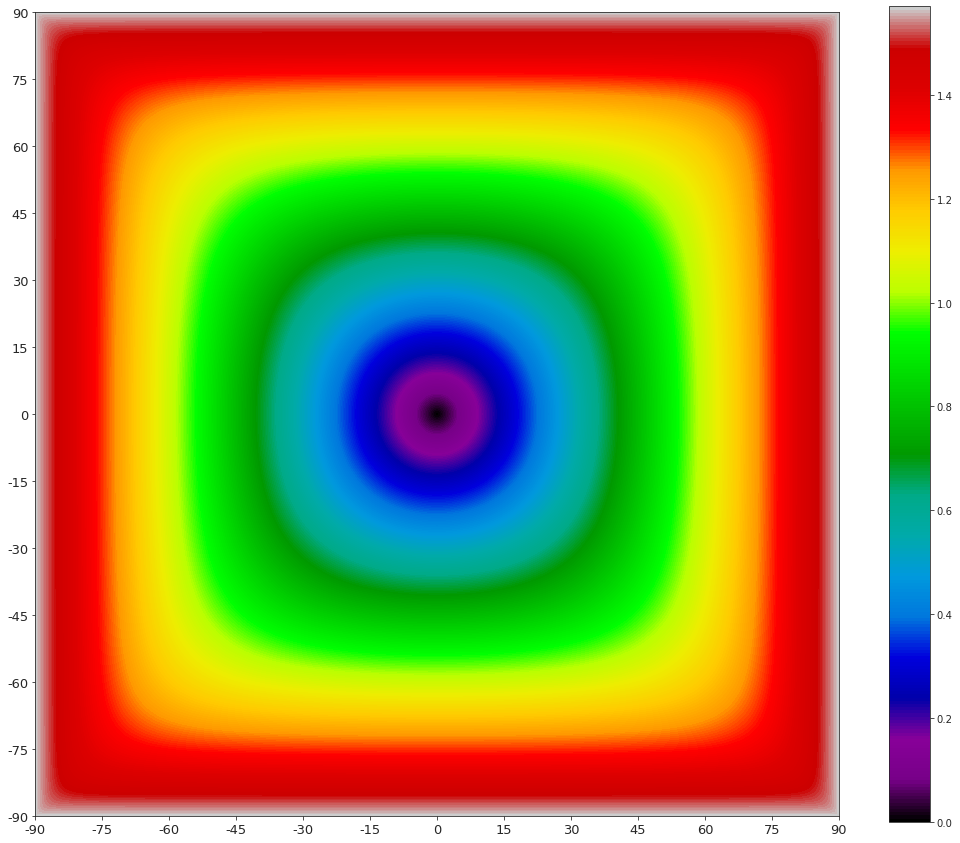

In [9]:
fig, ax = create_figure(1, 1, (18, 15))
im = ax.imshow(theta, vmin=0, cmap='nipy_spectral')
plt.colorbar(im, ax=ax)

ax.invert_yaxis()
ax.tick_params(labelsize=13)
ax.set(
    xticks=ticks,
    yticks=ticks,
    xticklabels=ticklabels,
    yticklabels=ticklabels,
)
plt.show()

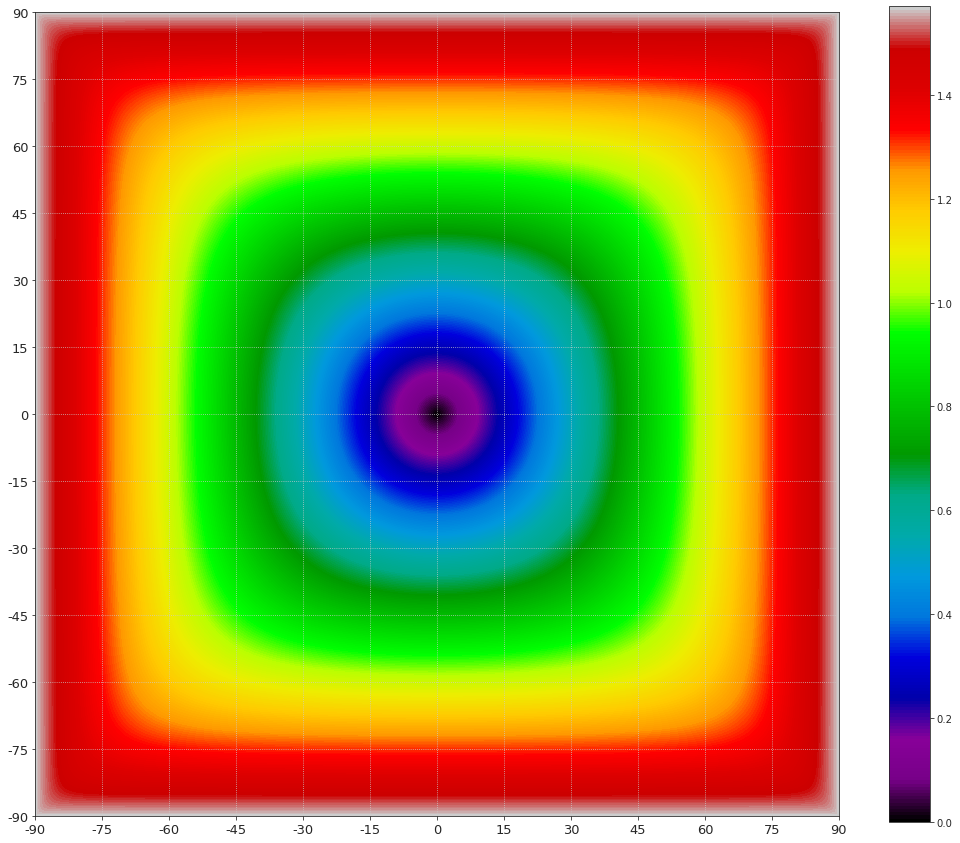

In [10]:
ax.grid()
fig

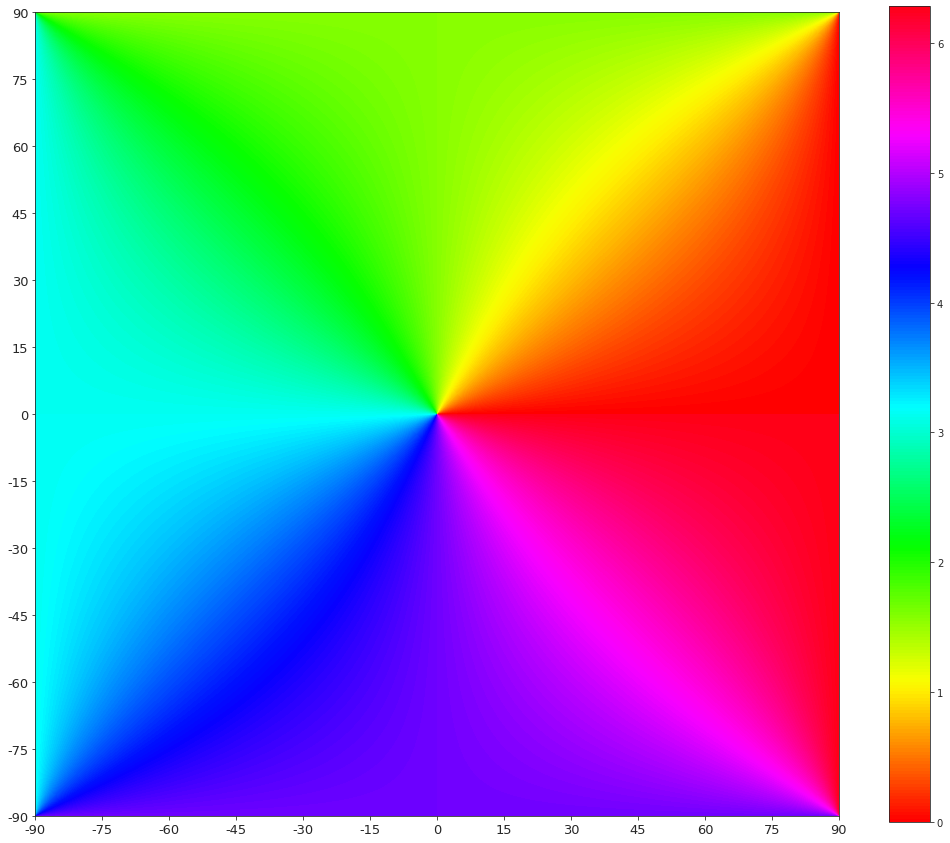

In [11]:
fig, ax = create_figure(1, 1, (18, 15))
im = ax.imshow(phi, vmin=0, vmax=2*np.pi, cmap='hsv')
plt.colorbar(im, ax=ax)

ax.invert_yaxis()
ax.tick_params(labelsize=13)
ax.set(
    xticks=ticks,
    yticks=ticks,
    xticklabels=ticklabels,
    yticklabels=ticklabels,
)
plt.show()

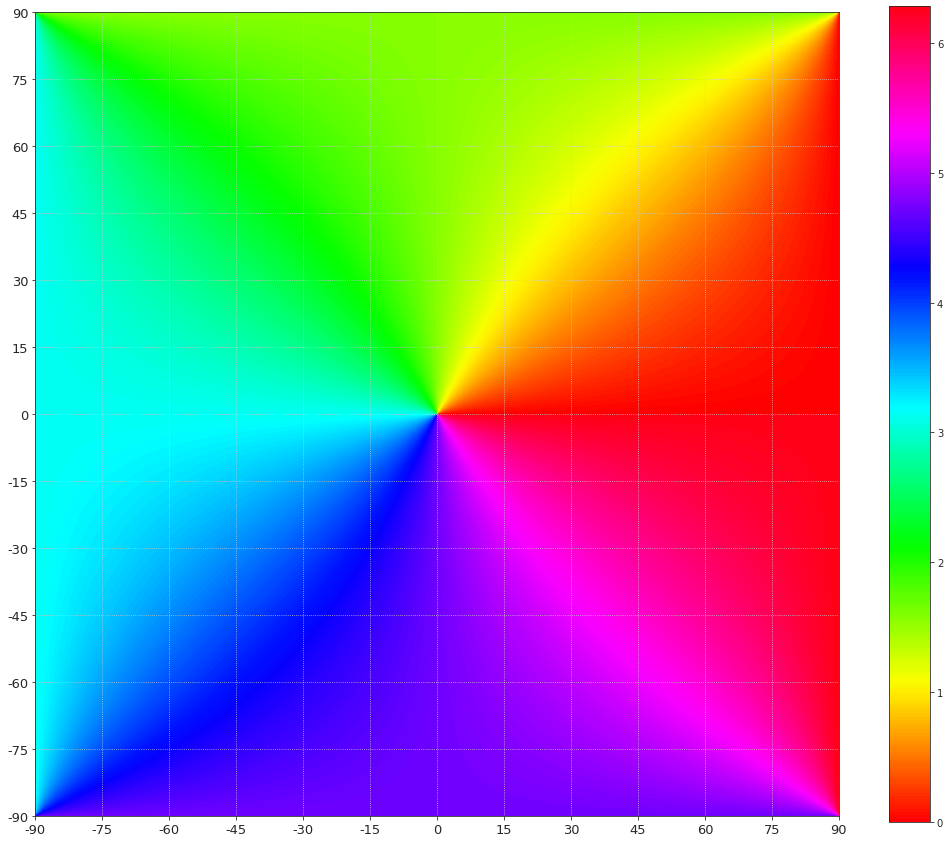

In [12]:
ax.grid()
fig

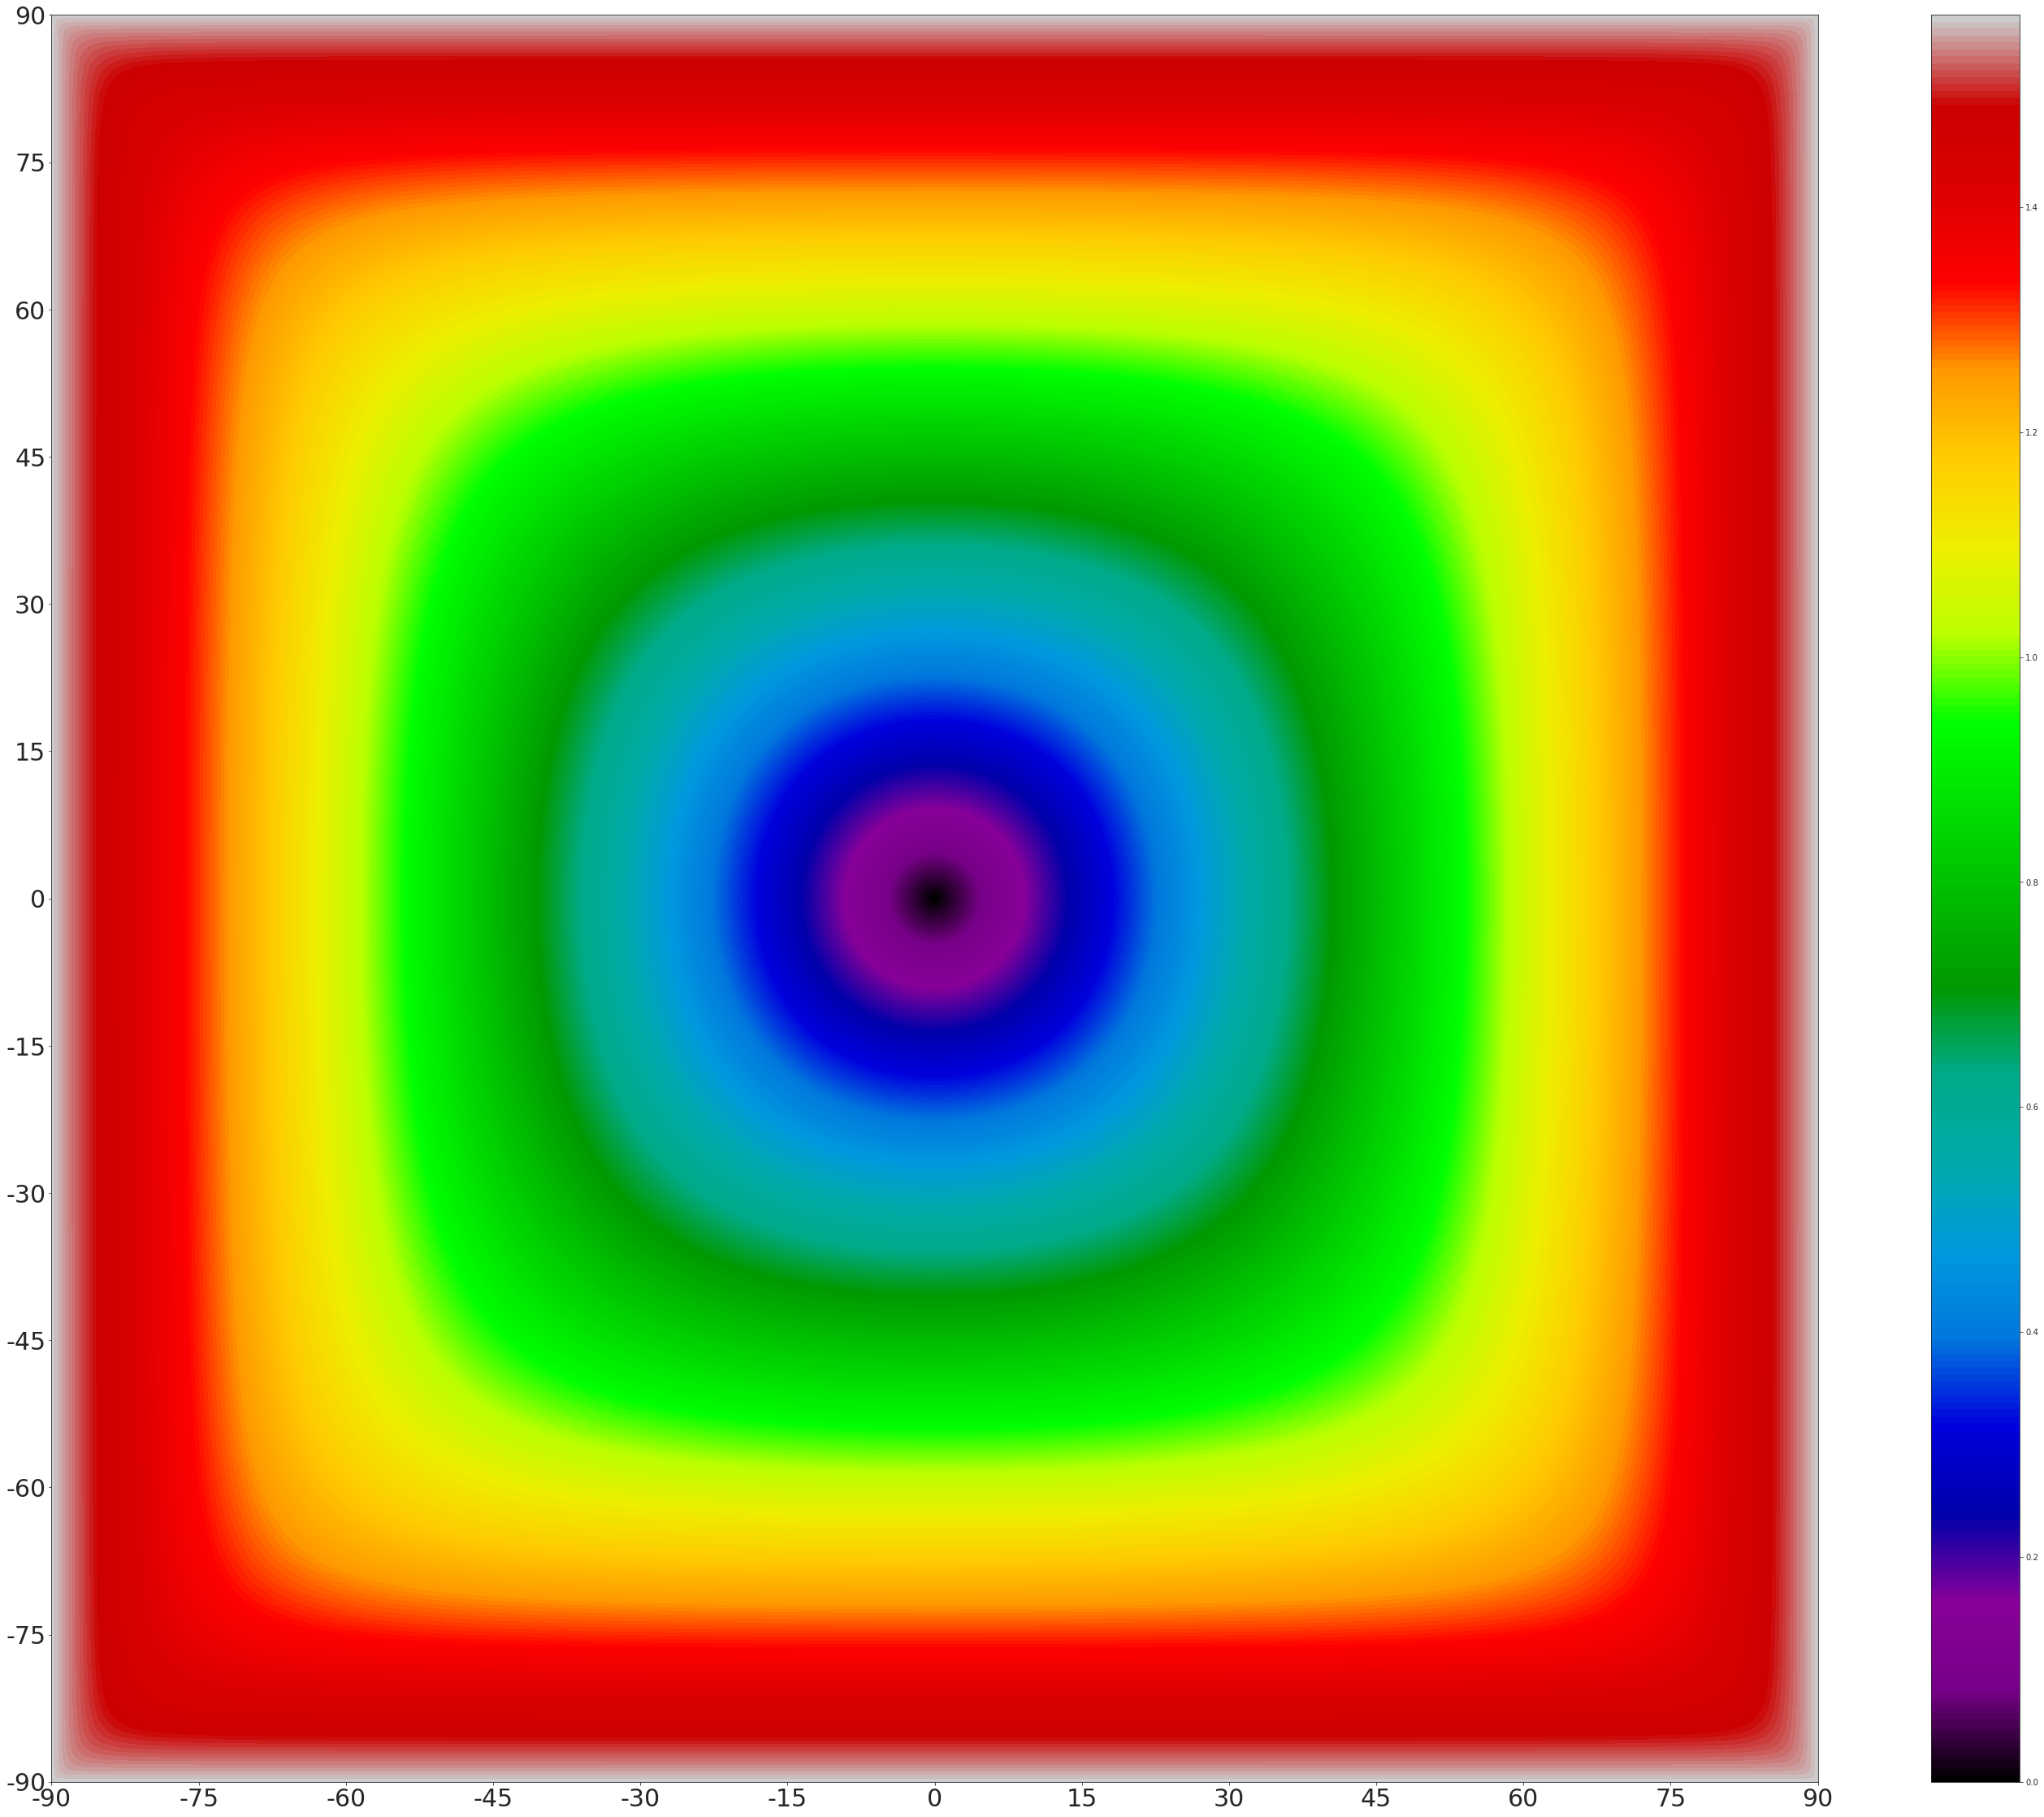

In [14]:
fig, ax = create_figure(1, 1, (50, 40))
im = ax.imshow(theta, vmin=0, cmap='nipy_spectral')
plt.colorbar(im, ax=ax)

ax.invert_yaxis()
ax.tick_params(labelsize=30)
ax.set(
    xticks=ticks,
    yticks=ticks,
    xticklabels=ticklabels,
    yticklabels=ticklabels,
)
plt.show()

### Low res

In [106]:
resolution = 0.1
fov = 60
extent = 90

span = np.linspace(-extent, extent, int(np.round(2 * extent / resolution)) + 1)
span = np.deg2rad(span)

alpha_x, alpha_y = np.meshgrid(span, span)
theta, phi = one(alpha_x, alpha_y)

len(span), alpha_x.shape, alpha_y.shape

(1801, (1801, 1801), (1801, 1801))

In [107]:
ticks, ticklabels = zip(*[
    (i, str(int(np.round(np.rad2deg(x)))))
    for i, x in enumerate(span) if i % 300 == 0
])
ticklabels

('-90', '-60', '-30', '0', '30', '60', '90')

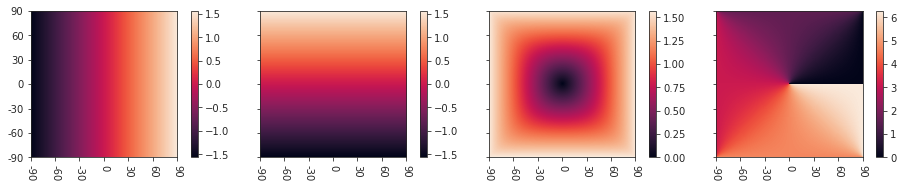

In [108]:
fig, axes = create_figure(1, 4, (12.5, 2.5), 'all', 'all', constrained_layout=True)
for i in range(2):
    x2p = alpha_x if i == 0 else alpha_y
    im = axes[i].imshow(x2p.astype(float))
    plt.colorbar(im, ax=axes[i])

    x2p = theta if i == 0 else phi
    im = axes[2 + i].imshow(x2p.astype(float))
    plt.colorbar(im, ax=axes[2 + i])

axes[-1].invert_yaxis()
axes[-1].set(
    xticks=ticks,
    yticks=ticks,
    xticklabels=ticklabels,
    yticklabels=ticklabels,
)
for ax in axes.flat:
    ax.tick_params(axis='x', rotation=-90)

In [109]:
np.rad2deg(np.max(theta))

89.999999999999997516

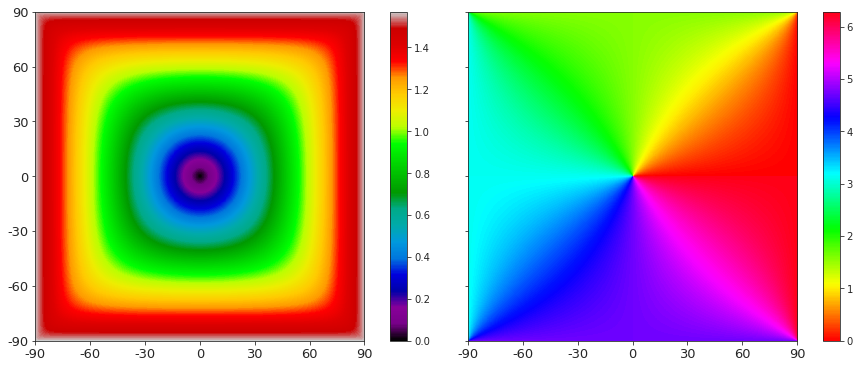

In [110]:
fig, axes = create_figure(1, 2, (12, 5), 'all', 'all', constrained_layout=True)
im = axes[0].imshow(theta.astype(float), vmin=0, vmax=np.pi/2, cmap='nipy_spectral')
plt.colorbar(im, ax=axes[0])

im = axes[1].imshow(phi.astype(float), vmin=0, vmax=2*np.pi, cmap='hsv')
plt.colorbar(im, ax=axes[1])

axes[-1].invert_yaxis()
for ax in axes.flat:
    ax.tick_params(labelsize=13)
    ax.set(
        xticks=ticks,
        yticks=ticks,
        xticklabels=ticklabels,
        yticklabels=ticklabels,
    )
plt.show()

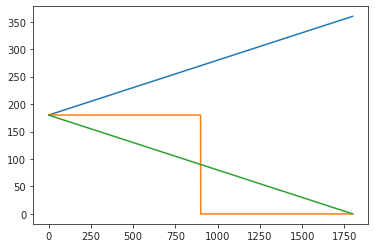

In [112]:
plt.plot(np.rad2deg(phi[450]))
plt.plot(np.rad2deg(phi[900]))
plt.plot(np.rad2deg(phi[1350]))

In [123]:
valid = np.abs(span) <= np.deg2rad(fov)

In [125]:
ticks, ticklabels = zip(*[
    (i, str(int(np.round(np.rad2deg(x)))))
    for i, x in enumerate(span[valid]) if i % 200 == 0
])
ticklabels

('-60', '-40', '-20', '0', '20', '40', '60')

In [126]:
np.rad2deg(np.max(theta[valid][:, valid]))

67.7923457014035072

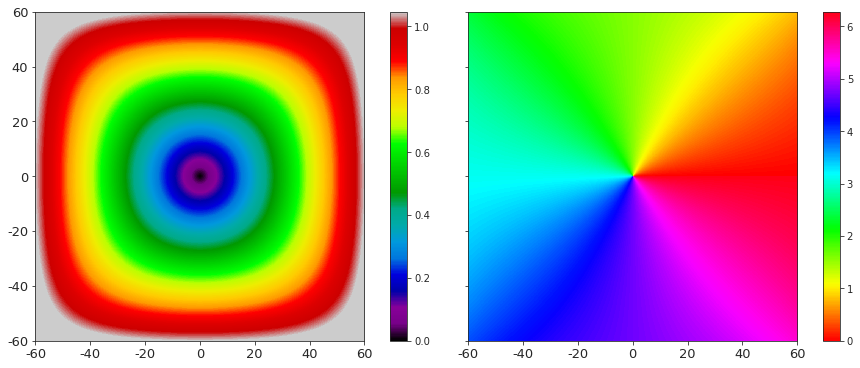

In [127]:
fig, axes = create_figure(1, 2, (12, 5), 'all', 'all', constrained_layout=True)
im = axes[0].imshow(theta.astype(float)[valid][:, valid], vmin=0, vmax=np.deg2rad(fov), cmap='nipy_spectral')
plt.colorbar(im, ax=axes[0])

im = axes[1].imshow(phi.astype(float)[valid][:, valid], vmin=0, vmax=2*np.pi, cmap='hsv')
plt.colorbar(im, ax=axes[1])

axes[-1].invert_yaxis()
for ax in axes.flat:
    ax.tick_params(labelsize=13)
    ax.set(
        xticks=ticks,
        yticks=ticks,
        xticklabels=ticklabels,
        yticklabels=ticklabels,
    )
plt.show()

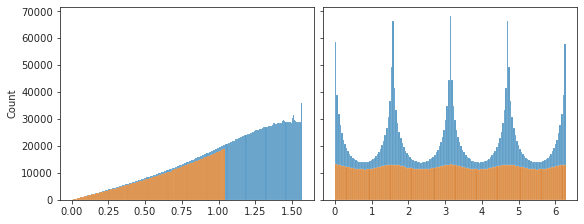

In [128]:
fig, axes = create_figure(1, 2, (8, 3), sharey='all', constrained_layout=True)
sns.histplot(theta.ravel(), color='C0', ax=axes[0])
sns.histplot(theta[theta < np.deg2rad(fov)], color='C1', ax=axes[0])

sns.histplot(phi.ravel(), color='C0', ax=axes[1])
sns.histplot(phi[theta < np.deg2rad(fov)], color='C1', ax=axes[1])
plt.show()

In [129]:
z = 10
r = z / np.cos(theta)
x = r * np.sin(theta) * np.cos(phi)
y = r * np.sin(theta) * np.sin(phi)

r = r[valid][:, valid]
x = x[valid][:, valid]
y = y[valid][:, valid]

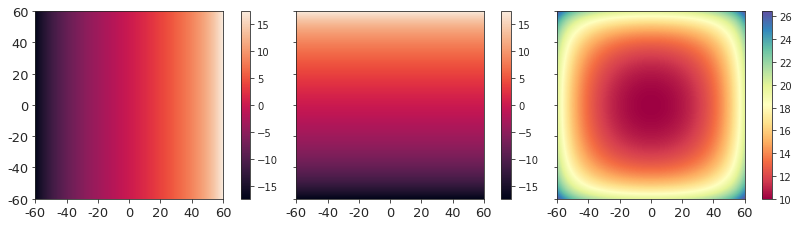

In [139]:
fig, axes = create_figure(1, 3, (11, 3.0), 'all', 'all', constrained_layout=True)
im = axes[0].imshow(x.astype(float))
plt.colorbar(im, ax=axes[0])

im = axes[1].imshow(y.astype(float))
plt.colorbar(im, ax=axes[1])

im = axes[2].imshow(r.astype(float), cmap='Spectral')
plt.colorbar(im, ax=axes[2])

axes[-1].invert_yaxis()
for ax in axes.flat:
    ax.tick_params(labelsize=13)
    ax.set(
        xticks=ticks,
        yticks=ticks,
        xticklabels=ticklabels,
        yticklabels=ticklabels,
    )
plt.show()

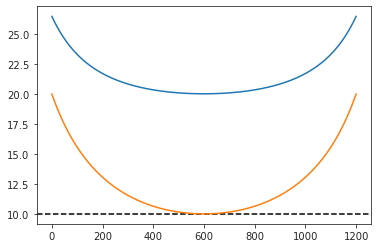

In [140]:
plt.axhline(10, color='k', ls='--')
plt.plot(r[0])
plt.plot(r[600])

In [147]:
np.min(x), np.max(x), np.min(y), np.max(y)

(-17.320508075688772587,
 17.320508075688768344,
 -17.32050807568877259,
 17.320508075688768346)

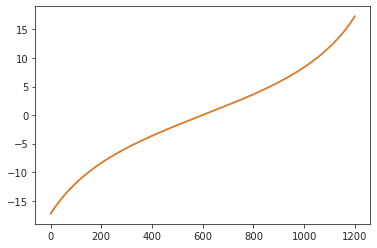

In [143]:
plt.plot(x[600])
plt.plot(y[:, 600])

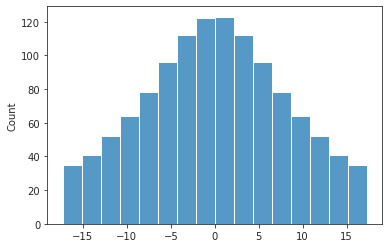

In [152]:
sns.histplot(x[600]);

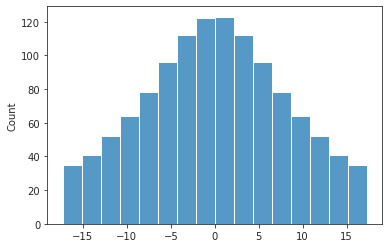

In [150]:
sns.histplot(y[:, 600]);

## Much better way to do it

Circumvents the need to calculate theta and phi altogether

In [175]:
z = 10
x = z * np.tan(alpha_x)
y = z * np.tan(alpha_y)
r = np.sqrt(x**2 + y**2 + z**2)

r = r[valid][:, valid]
x = x[valid][:, valid]
y = y[valid][:, valid]

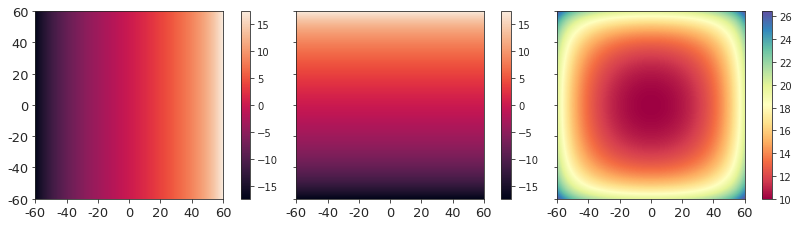

In [176]:
fig, axes = create_figure(1, 3, (11, 3.0), 'all', 'all', constrained_layout=True)
im = axes[0].imshow(x.astype(float))
plt.colorbar(im, ax=axes[0])

im = axes[1].imshow(y.astype(float))
plt.colorbar(im, ax=axes[1])

im = axes[2].imshow(r.astype(float), cmap='Spectral')
plt.colorbar(im, ax=axes[2])

axes[-1].invert_yaxis()
for ax in axes.flat:
    ax.tick_params(labelsize=13)
    ax.set(
        xticks=ticks,
        yticks=ticks,
        xticklabels=ticklabels,
        yticklabels=ticklabels,
    )
plt.show()

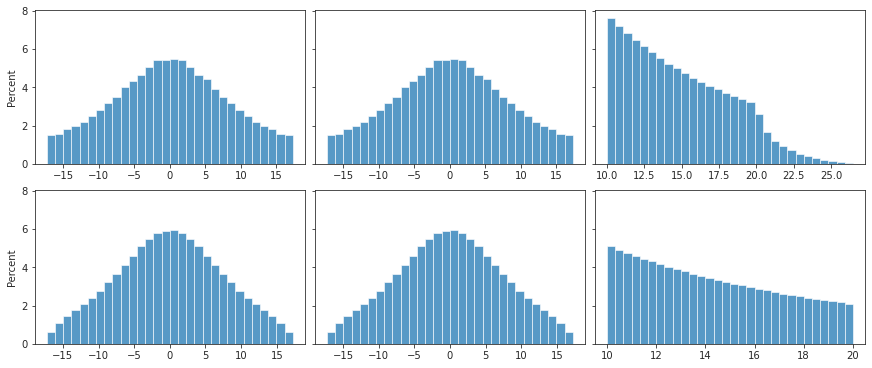

In [177]:
fig, axes = create_figure(2, 3, (12, 5), sharey='all', constrained_layout=True)
sns.histplot(x.ravel(), ax=axes[0, 0], bins=30, stat='percent')
sns.histplot(y.ravel(), ax=axes[0, 1], bins=30, stat='percent')
sns.histplot(r.ravel(), ax=axes[0, 2], bins=30, stat='percent')

sns.histplot(x[theta[valid][:, valid] < np.deg2rad(fov)], ax=axes[1, 0], bins=30, stat='percent')
sns.histplot(y[theta[valid][:, valid] < np.deg2rad(fov)], ax=axes[1, 1], bins=30, stat='percent')
sns.histplot(r[theta[valid][:, valid] < np.deg2rad(fov)], ax=axes[1, 2], bins=30, stat='percent')
plt.show()

## Ending remarks

- Now I have established a solid relationship between $(\alpha, \beta)$, $(\theta, \phi)$, and $(x, y)$ pairs.
- Maybe -60/+60 is too wide, cosinder narrowing it down.
- Next up: figure out this mapping for arbitrary fixations.
- Finally: differentiate both sides to get anuglar velocities. i.e., $(\dot{\alpha}, \dot{\beta})$.

## Old (scratch)

In [155]:
def do_it(theta, phi):
    theta = np.deg2rad(theta)
    phi = np.deg2rad(phi)
    
    e = polar2cart((1, theta, phi))
    alpha_y = np.arcsin(np.sin(theta) * np.sin(phi))
    alpha_x = np.arcsin(np.sin(theta) * np.cos(phi))
    r = (
        alpha_x * np.array([0, 1, 0]) +
        alpha_y * np.array([1, 0, 0])
    )
    r = rot.from_rotvec(r)
    e = r.apply(e)
    return e, alpha_y, alpha_x

In [156]:
do_it(60, 20)

(array([ 0.91487357,  0.26422604, -0.30527192]),
 0.3007096981554272,
 0.9506573206628424)

In [157]:
do_it(85, 20)

(array([ 0.47797794,  0.47220574, -0.74064757]),
 0.34768118225047245,
 1.2114213108598169)

In [158]:
do_it(90, 1)

(array([ 0.01766842,  0.02848813, -0.99943797]),
 0.017453292519943295,
 1.553343034274955)

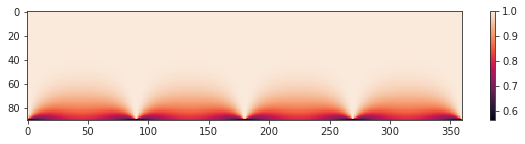

In [154]:
results = np_nans((90, 360))
for i, theta in enumerate(np.linspace(0, 90, 90)):
    for j, phi in enumerate(np.linspace(0, 360, 360)):
        results[i, j] = do_it(theta, phi)[0][-1]
        
fig, ax = create_figure(figsize=(10, 2))
im = ax.imshow(results, vmax=1)
plt.colorbar(im, ax=ax);

In [ ]:
def do_it(theta, phi):
    theta = np.deg2rad(theta)
    phi = np.deg2rad(phi)
    
    e = polar2cart((1, theta, phi))
    alpha_y = np.arctan(np.tan(theta) * np.sin(phi))
    alpha_x = np.arctan(np.tan(theta) * np.cos(phi) * -1)
    r = (
        alpha_x * np.array([0, 1, 0]) +
        alpha_y * np.array([1, 0, 0])
    )
    r = rot.from_rotvec(r)
    e = r.apply(e)
    return e, alpha_y, alpha_x

do_it(60, 20)

do_it(85, 20)

do_it(90, 1)



results = np_nans((90, 360))
for i, theta in enumerate(np.linspace(0, 90, 90)):
    for j, phi in enumerate(np.linspace(0, 360, 360)):
        results[i, j] = do_it(theta, phi)[0][-1]
        
fig, ax = create_figure(figsize=(10, 2))
im = ax.imshow(results, vmax=1)
plt.colorbar(im, ax=ax);



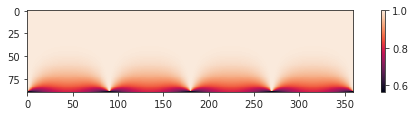

In [177]:
# norms = []
ez = np_nans((90, 360))
alpha = np_nans((90, 360, 2))
for i, theta in enumerate(np.linspace(0, 90, 90)):
    for j, phi in enumerate(np.linspace(0, 360, 360)):
        e, alpha_y, alpha_x = do_it(theta, phi)
        ez[i, j] = e[-1]
        alpha[i, j, 0] = alpha_x
        alpha[i, j, 1] = alpha_y
        # norms.append(sp_lin.norm(e))
        
fig, ax = create_figure(figsize=(10, 1.5))
im = ax.imshow(ez, vmax=1)
plt.colorbar(im, ax=ax);

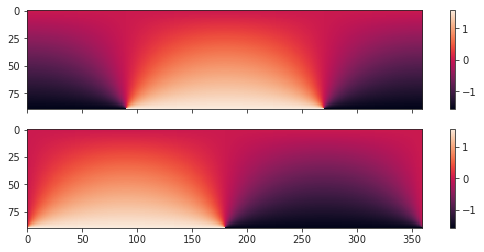

In [191]:
fig, axes = create_figure(2, 1, (10, 4), 'all', 'all')
im = axes[0].imshow(alpha[..., 0])
plt.colorbar(im, ax=axes[0])
im = axes[1].imshow(alpha[..., 1])
plt.colorbar(im, ax=axes[1])

In [287]:
def do_it(theta, phi):
    alpha_y = np.arctan(np.tan(theta) * np.sin(phi))
    alpha_x = np.arctan(np.tan(theta) * np.cos(phi) * -1)
    r = (
        alpha_x * np.array([0, 1, 0]) +
        alpha_y * np.array([1, 0, 0])
    )
    r = rot.from_rotvec(r)
    e = polar2cart((1, theta, phi))
    e = r.apply(e)
    return e, alpha_y, alpha_x

In [316]:
z = 100.0
width = 100
num = 2 * width + 1
span = np.linspace(-width, width, num)
ticks, ticklabels = zip(*[
    (i, str(int(x))) for i, x in
    enumerate(span) if i % 20 == 0
])
fov = 60

ez = np_nans((num, num))
alpha = np_nans((num, num, 2))
coords = np_nans((num, num, 2))
for i, x in enumerate(span):
    for j, y in enumerate(span):
        p = (x, y, z)
        r, theta, phi = cart2polar(p)
        # if phi < 0:
        #     phi += 2 * np.pi
        e, alpha_y, alpha_x = do_it(theta, phi)
        
        if theta > np.deg2rad(fov):
            continue
        ez[j, i] = e[-1]
        coords[j, i, 0] = theta
        coords[j, i, 1] = phi
        alpha[j, i, 0] = alpha_x
        alpha[j, i, 1] = alpha_y

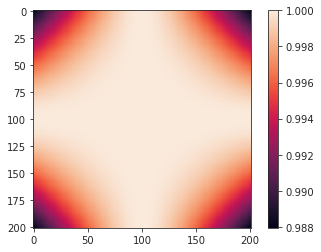

In [317]:
plt.imshow(ez)
plt.colorbar();

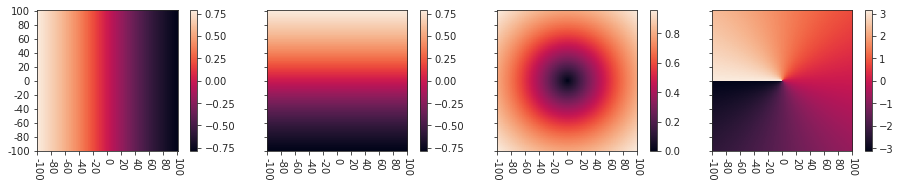

In [318]:
fig, axes = create_figure(1, 4, (12.5, 2.5), 'all', 'all', constrained_layout=True)
for i in range(2):
    im = axes[i].imshow(alpha[..., i])
    plt.colorbar(im, ax=axes[i])
    
    im = axes[2 + i].imshow(coords[..., i])
    plt.colorbar(im, ax=axes[2 + i])

axes[-1].invert_yaxis()
axes[-1].set(
    xticks=ticks,
    yticks=ticks,
    xticklabels=ticklabels,
    yticklabels=ticklabels,
)
for ax in axes.flat:
    ax.tick_params(axis='x', rotation=-90)

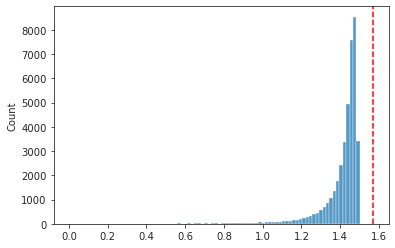

In [313]:
sns.histplot(coords[..., 0].ravel(), bins=np.linspace(0, np.pi/2, 91))
plt.axvline(np.pi/2, color='r', ls='--')
plt.show()

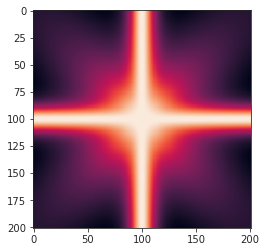

In [478]:
z = 1

resolution = 0.1
fov = 60
extent = 90
span = np.linspace(-extent, extent, int(np.round(2 * extent / resolution)) + 1)
span = np.deg2rad(span)[1:-1]
alpha_x, alpha_y = np.meshgrid(span, span)
len(span), alpha_x.shape, alpha_y.shape

(1799, (1799, 1799), (1799, 1799))

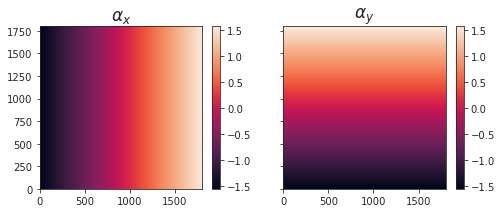

In [479]:
fig, axes = create_figure(1, 2, (8, 3), 'all', 'all')
im = axes[0].imshow(alpha_x)
axes[0].set_title(r'$\alpha_x$', fontsize=17)
plt.colorbar(im, ax=axes[0])

im = axes[1].imshow(alpha_y)
axes[1].set_title(r'$\alpha_y$', fontsize=17)
plt.colorbar(im, ax=axes[1])

axes[-1].invert_yaxis()
plt.show()

In [480]:
x, y = np.meshgrid(z * np.tan(span), z * np.tan(span))
valid = np.abs(span) < np.deg2rad(fov)
x = x[valid][:, valid]
y = y[valid][:, valid]
valid.sum()

1199

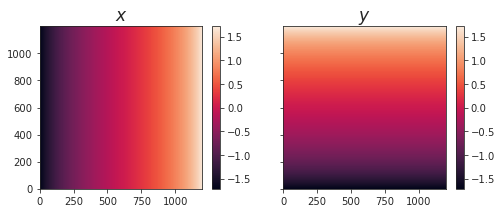

In [481]:
fig, axes = create_figure(1, 2, (8, 3), 'all', 'all')
im = axes[0].imshow(x)
axes[0].set_title(r'$x$', fontsize=17)
plt.colorbar(im, ax=axes[0])

im = axes[1].imshow(y)
axes[1].set_title(r'$y$', fontsize=17)
plt.colorbar(im, ax=axes[1])

axes[-1].invert_yaxis()
plt.show()

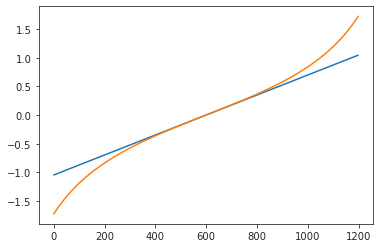

In [482]:
plt.plot(alpha_x[1][valid])
plt.plot(x[1]);

In [483]:
phi = np.arctan2(y, x)
phi[phi < 0] += 2 * np.pi

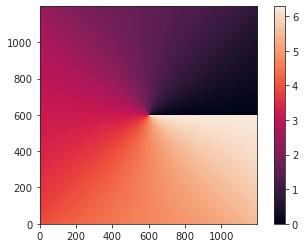

In [486]:
fig, ax = create_figure()
im = ax.imshow(phi)
plt.colorbar(im, ax=ax)
ax.invert_yaxis()

In [487]:
phi.shape

(1199, 1199)

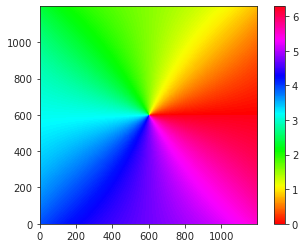

In [488]:
fig, ax = create_figure()
im = ax.imshow(phi, cmap='hsv')
plt.colorbar(im, ax=ax)
ax.invert_yaxis()

In [503]:
a, b = np.meshgrid(np.tan(span) ** 2, np.tan(span) ** 2)
theta = np.arctan(np.sqrt(a + b))

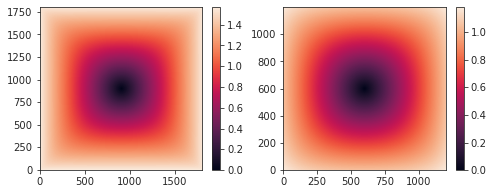

In [509]:
fig, axes = create_figure(1, 2, (8, 3))
im = axes[0].imshow(theta)
plt.colorbar(im, ax=axes[0])
im = axes[1].imshow(theta[valid][:, valid])
plt.colorbar(im, ax=axes[1])
for ax in axes.flat:
    ax.invert_yaxis()
plt.show()

<AxesSubplot:ylabel='Count'>

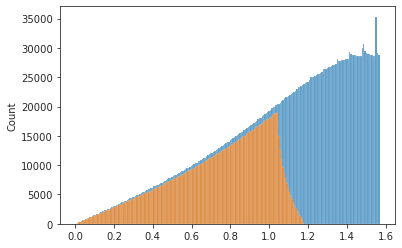

In [512]:
sns.histplot(theta.ravel(), color='C0')
sns.histplot(theta[valid][:, valid].ravel(), color='C1')

<AxesSubplot:ylabel='Percent'>

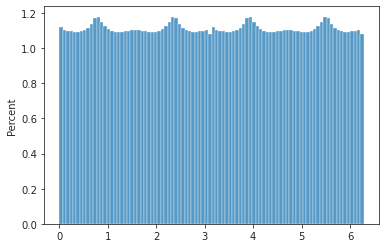

In [513]:
sns.histplot(phi.ravel(), bins=np.linspace(0, 2 * np.pi, 91), stat='percent')

In [514]:
mask = theta < np.deg2rad(fov)

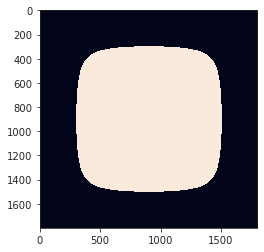

In [515]:
plt.imshow(mask)

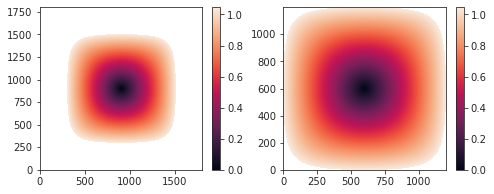

In [518]:
fig, axes = create_figure(1, 2, (8, 3))
im = axes[0].imshow(mwh(theta >= np.deg2rad(fov), theta))
plt.colorbar(im, ax=axes[0])
x2p = mwh(theta[valid][:, valid] >= np.deg2rad(fov), theta[valid][:, valid])
im = axes[1].imshow(x2p)
plt.colorbar(im, ax=axes[1])
for ax in axes.flat:
    ax.invert_yaxis()
plt.show()

In [519]:
mask = theta[valid][:, valid] < np.deg2rad(fov)

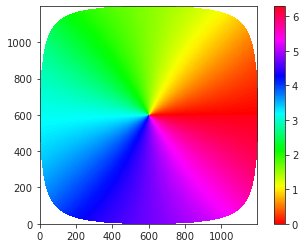

In [521]:
fig, ax = create_figure()
im = ax.imshow(mwh(~mask, phi), cmap='hsv')
plt.colorbar(im, ax=ax)
ax.invert_yaxis()

<AxesSubplot:ylabel='Percent'>

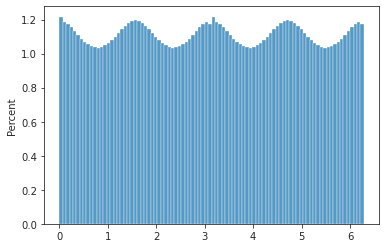

In [522]:
sns.histplot(phi[mask], bins=np.linspace(0, 2 * np.pi, 91), stat='percent')

<AxesSubplot:ylabel='Count'>

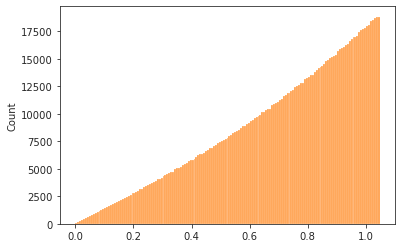

In [524]:
x2p = theta[valid][:, valid]
x2p = x2p[x2p < np.deg2rad(fov)]
sns.histplot(x2p, color='C1')

In [495]:
np.deg2rad(fov)

1.0471975511965976

<AxesSubplot:ylabel='Count'>

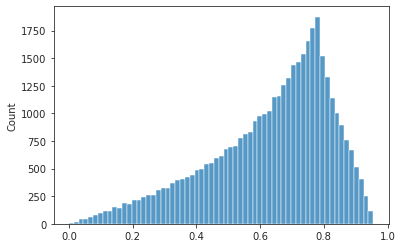

In [497]:
sns.histplot(coords[..., 0].ravel())

In [477]:
phi.shape

(1199, 1199)

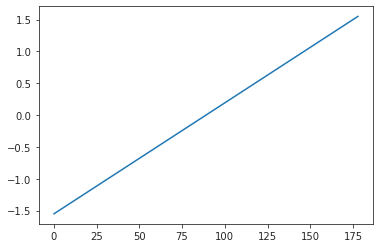

119

In [399]:
xy[valid][:, valid].shape

(119, 119)

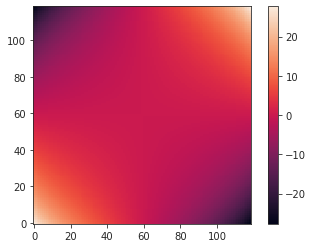

In [400]:
fig, ax = create_figure()
im = ax.imshow(xy[valid][:, valid])
plt.colorbar(im, ax=ax)
ax.invert_yaxis()

In [404]:
xy[valid][:, valid][0, 0], xy[valid][:, valid][-1, -1]

(27.698261953729094, 27.698261953729094)

In [405]:
xy[valid][:, valid][0, 0], xy[valid][:, valid][0, -1]

(27.698261953729094, -27.698261953729094)

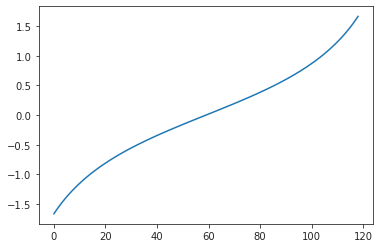

In [408]:
plt.plot(np.tan(span)[valid])

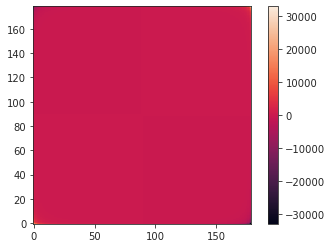

In [398]:
fig, ax = create_figure()
im = ax.imshow(xy)
plt.colorbar(im, ax=ax)
ax.invert_yaxis()

In [355]:
np.tan(0)

0.0

In [475]:
u = np.deg2rad(5)
np.log(np.sin(u/2)) - np.log(np.cos(u/2))

-3.131301331471645